In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math, scipy
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model, metrics
import time
from model.Least_Square import Least_Square
from opt_algorithms.gradient_descent import gradient_descent
from opt_algorithms.accelerated_gradient_descent import accelerated_gradient_descent
from opt_algorithms.newton_method import newton_method
from my_utils.visualization import *

In [33]:
s = "../data/kc_house_data.csv"
print('From local House path:', s)
df_housesales = pd.read_csv(s, encoding='utf-8')
df_housesales['price'] = df_housesales['price'].apply(lambda x: x/1e6)
df_housesales = df_housesales[df_housesales['bedrooms']!=33]
df_housesales.head()

From local House path: ../data/kc_house_data.csv


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,0.2219,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,0.5380,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,0.1800,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,0.6040,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,0.5100,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [34]:
ids = df_housesales.id.value_counts().to_frame()
ids[ids.id>=2]

,id
795000620,3
8651510380,2
7409700215,2
1995200200,2
9211500620,2
...,...
2787460720,2
3332000615,2
2206700215,2
6021501535,2


In [35]:
# Drop duplicated id
df_housesales = df_housesales.sort_values(by=['id']).drop_duplicates(subset=['id'], keep='last')

In [36]:
# Tranform Date to year, month and Drop id, Date
df_housesales['date'] = pd.to_datetime(df_housesales['date'])
df_housesales['year'] = df_housesales['date'].apply(lambda date: date.year)
df_housesales['month'] = df_housesales['date'].apply(lambda date: date.month)

In [37]:
df_housesales['yr_renovated'] = [str(x) + '-01-01' if x!=0 else str(y) + '-01-01'
                                 for x, y in zip(df_housesales['yr_renovated'].values,
                                                 df_housesales['yr_built'].values)]
df_housesales['yr_renovated'] = pd.to_datetime(df_housesales['yr_renovated'].apply(lambda x: str(x) + '-01-01'))
df_housesales['yr_built'] = pd.to_datetime(df_housesales['yr_built'].apply(lambda x: str(x) + '-01-01'))


In [38]:
df_housesales['yr_built'] = pd.to_datetime(df_housesales['yr_built'])
df_housesales['yr_renovated'] = pd.to_datetime(df_housesales['yr_renovated'])
df_housesales['built_age'] = [x - y for x,y in
                                  zip(df_housesales['date'].apply(lambda x: x.year),
                                      df_housesales['yr_built'].apply(lambda x: x.year))]
df_housesales['renovated_age'] = [x - y for x,y in
                                  zip(df_housesales['date'].apply(lambda x: x.year),
                                      df_housesales['yr_renovated'].apply(lambda x: x.year))]


In [39]:
# dropping
df_housesales.drop(['id','date','yr_built','yr_renovated'], axis = 1, inplace = True)

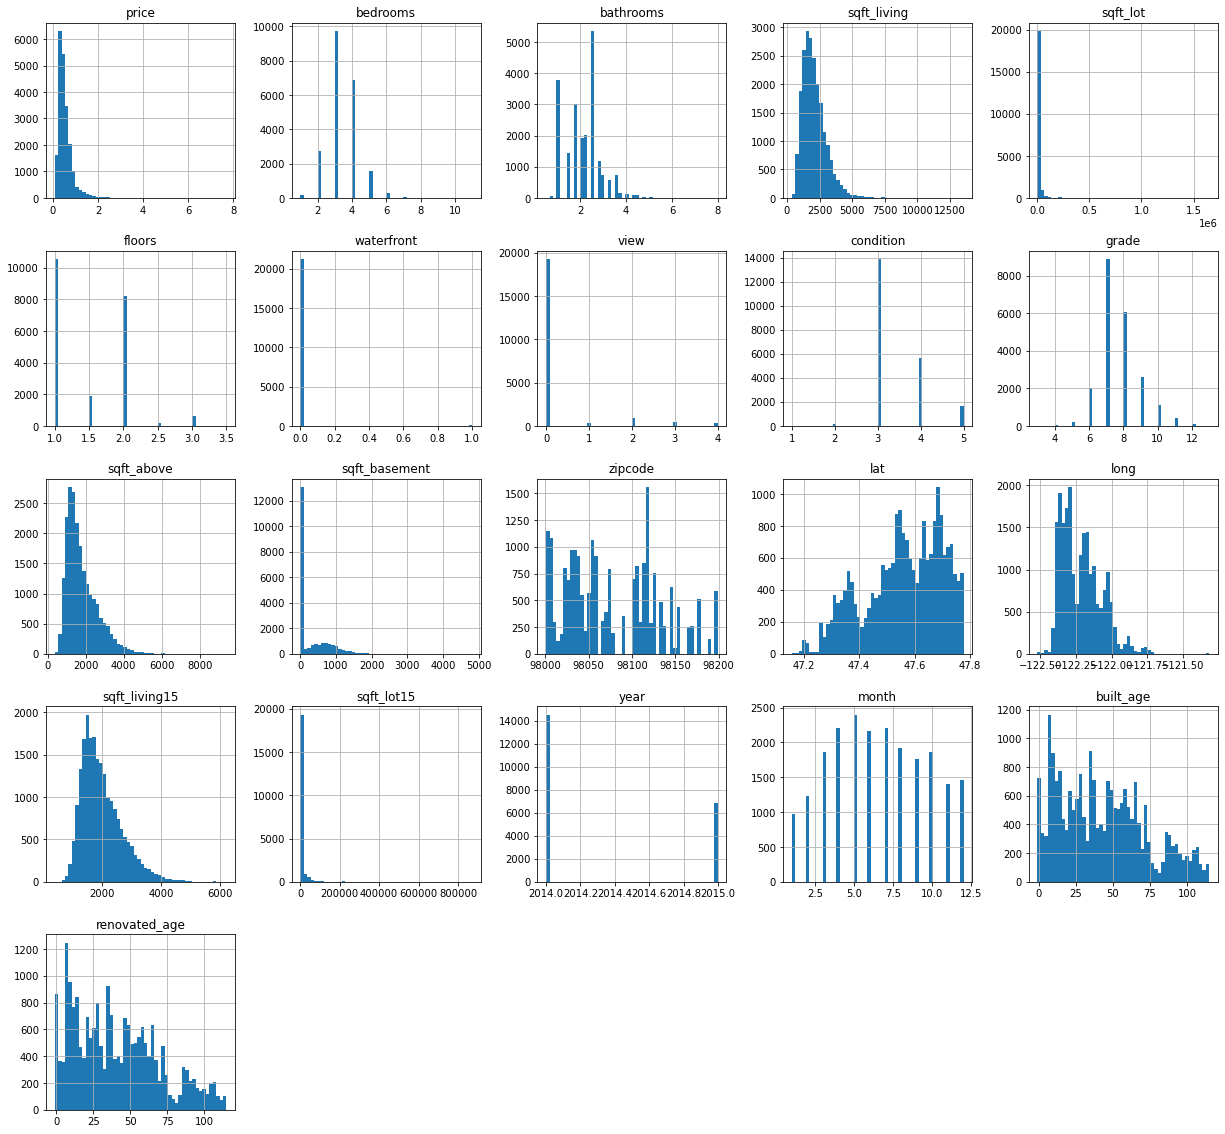

In [40]:
df_housesales.hist(bins=50, figsize=(21, 20))
plt.show()

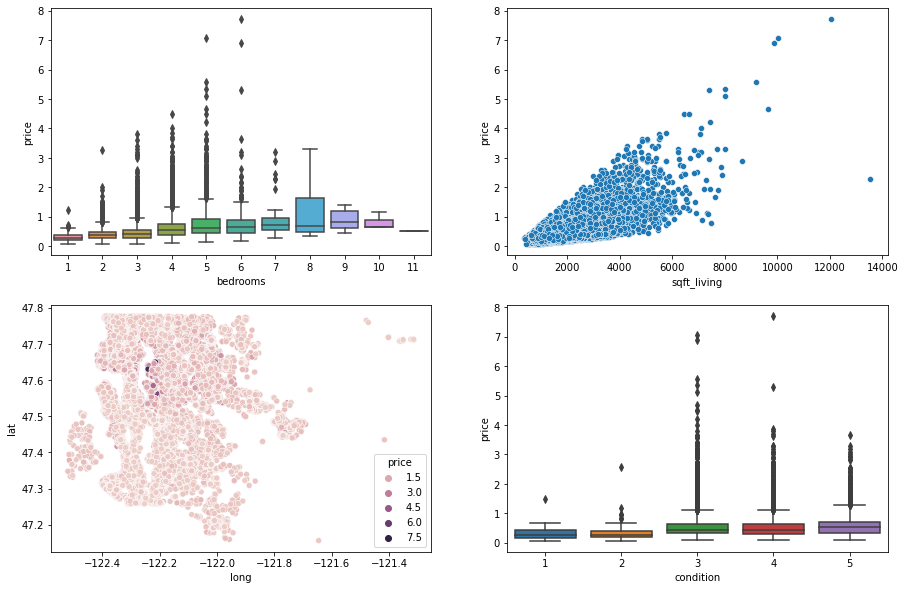

In [41]:
f,ax = plt.subplots(2,2, figsize = (15,10))
y = 'price'
sns.boxplot(x='condition', y=y, data=df_housesales , ax = ax[1,1])
sns.scatterplot(x='sqft_living',y=y ,data=df_housesales , ax = ax[0,1])
sns.scatterplot(x='long',y='lat',hue=y ,data=df_housesales , ax = ax[1,0])
sns.boxplot(x='bedrooms',y=y ,data=df_housesales , ax = ax[0,0]);

In [42]:
numerical = df_housesales.select_dtypes(['int64', 'float64'])
categorical = df_housesales.select_dtypes('object')

In [43]:
FC = df_housesales.corr() # Features Correlation
Target = numerical.corr()['price'].to_frame().reset_index() #Feature Correlation related to SalePrice
FR = FC.unstack().to_frame(name='Correlation') # Feature Relation
Feature = FR[(FR['Correlation']>=0.8)|(FR['Correlation']<=-0.8)].sort_values(by='Correlation', ascending = False).reset_index()
Final  = Feature.merge(Target,left_on='level_1', right_on='index')
Final = Final[Final['level_0'] != Final['level_1']]
#print("In thisdata set these columns are strongly related , i will usually take one and drop the other one but in this case i will keep it ")
Final

,level_0,level_1,Correlation,index,price
3,renovated_age,built_age,0.909456,built_age,-0.052136
13,sqft_living,sqft_above,0.876534,sqft_above,0.605082
21,sqft_above,sqft_living,0.876534,sqft_living,0.701769
24,built_age,renovated_age,0.909456,renovated_age,-0.104056


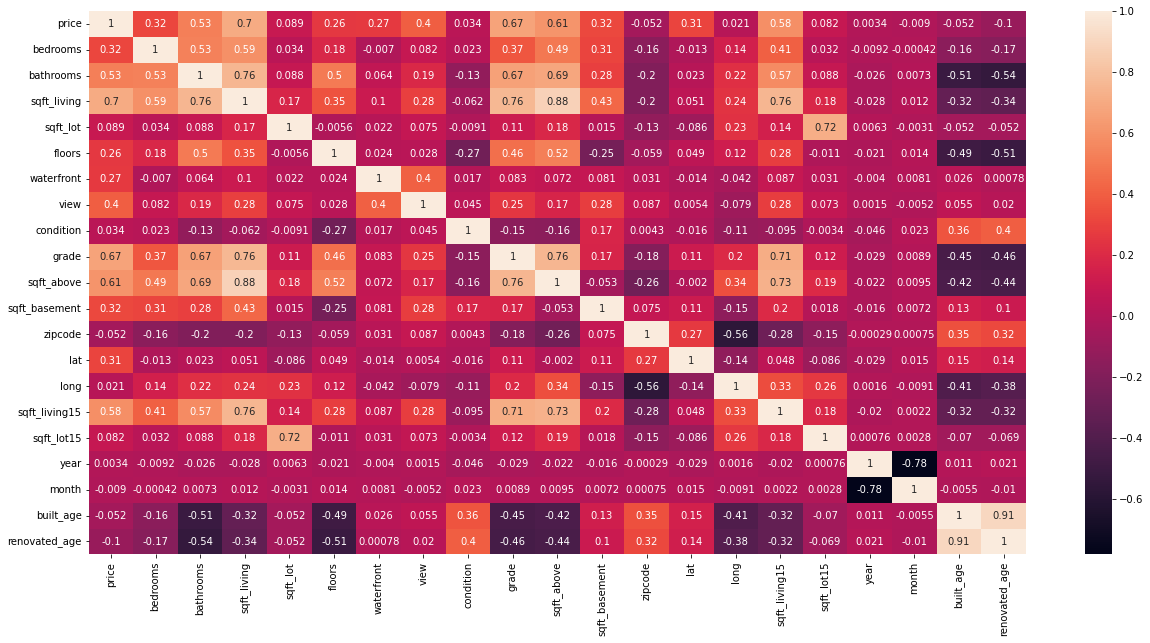

In [44]:
plt.figure(figsize=(21,10))
corr_matrix = df_housesales.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show();

In [45]:
drop_cols = ['sqft_above','year','built_age','sqft_lot15','long']
df_housesales = df_housesales.drop(columns=drop_cols)

In [46]:
# scikit-learn k-fold cross-validation
from numpy import array
from sklearn.model_selection import KFold
# data sample
# data = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,0.9])
# prepare cross validation
kf = KFold(n_splits=3, shuffle=False)
path = '../data/'
train_path = path + 'train'
test_path = path + 'test'
for i, (t_ind, v_ind) in enumerate(kf.split(df_housesales)):
    X_train = df_housesales.iloc[t_ind]     # train set
    X_test = df_housesales.iloc[v_ind]     # validation set
    X_train.to_csv(train_path + str(i) + '.csv', index=False)
    X_test.to_csv(test_path + str(i) + '.csv', index=False)
    print(t_ind, v_ind)
    display(X_train.describe())

[ 7140  7141  7142 ... 21416 21417 21418] [   0    1    2 ... 7137 7138 7139]


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,zipcode,lat,sqft_living15,month,renovated_age
count,14279.000000,14279.000000,14279.000000,14279.000000,1.427900e+04,14279.000000,14279.000000,14279.000000,14279.000000,14279.000000,14279.000000,14279.000000,14279.000000,14279.000000,14279.000000,14279.000000
mean,0.534805,3.369844,2.113646,2066.632117,1.125839e+04,1.497234,0.007423,0.238322,3.402339,7.655998,292.730583,98078.579662,47.562013,1979.366552,6.575741,40.765460
std,0.358199,0.898858,0.755369,892.779553,2.511815e+04,0.536824,0.085842,0.774379,0.648009,1.147427,441.938694,53.441773,0.138490,682.389639,3.109230,29.056858
min,0.080000,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,4.000000,0.000000,98001.000000,47.155900,460.000000,1.000000,-1.000000
25%,0.325000,3.000000,1.750000,1430.000000,5.000000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,0.000000,98033.000000,47.479300,1490.000000,4.000000,14.500000
50%,0.450000,3.000000,2.250000,1910.000000,7.395000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,0.000000,98065.000000,47.573200,1830.000000,6.000000,37.000000
75%,0.635000,4.000000,2.500000,2530.000000,1.011650e+04,2.000000,0.000000,0.000000,4.000000,8.000000,560.000000,98118.000000,47.680650,2350.000000,9.000000,60.000000
max,7.700000,10.000000,8.000000,12050.000000,1.164794e+06,3.500000,1.000000,4.000000,5.000000,13.000000,3480.000000,98199.000000,47.777600,6110.000000,12.000000,115.000000


[    0     1     2 ... 21416 21417 21418] [ 7140  7141  7142 ... 14277 14278 14279]


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,zipcode,lat,sqft_living15,month,renovated_age
count,14279.000000,14279.000000,14279.000000,14279.000000,1.427900e+04,14279.000000,14279.000000,14279.000000,14279.000000,14279.000000,14279.000000,14279.000000,14279.000000,14279.000000,14279.000000,14279.000000
mean,0.543077,3.372995,2.129438,2094.294208,1.608668e+04,1.505568,0.007914,0.235451,3.401219,7.675327,283.901254,98077.459906,47.559039,1998.456334,6.556972,40.299811
std,0.371309,0.900943,0.767958,927.556056,4.517309e+04,0.540897,0.088609,0.769135,0.642847,1.175842,437.676355,52.515620,0.136786,691.395074,3.122083,28.990946
min,0.078000,1.000000,0.500000,380.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,0.000000,98001.000000,47.155900,399.000000,1.000000,-1.000000
25%,0.320000,3.000000,1.750000,1440.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,0.000000,98033.000000,47.469550,1490.000000,4.000000,15.000000
50%,0.455000,3.000000,2.250000,1930.000000,7.579000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,0.000000,98065.000000,47.573200,1860.000000,6.000000,36.000000
75%,0.650000,4.000000,2.500000,2570.000000,1.072300e+04,2.000000,0.000000,0.000000,4.000000,8.000000,540.000000,98117.000000,47.673600,2390.000000,9.000000,60.000000
max,7.700000,11.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,4820.000000,98199.000000,47.777600,6210.000000,12.000000,115.000000


[    0     1     2 ... 14277 14278 14279] [14280 14281 14282 ... 21416 21417 21418]


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,zipcode,lat,sqft_living15,month,renovated_age
count,14280.000000,14280.000000,14280.000000,14280.000000,1.428000e+04,14280.000000,14280.000000,14280.000000,14280.000000,14280.000000,14280.000000,14280.000000,14280.000000,14280.000000,14280.000000,14280.000000
mean,0.545840,3.374860,2.112255,2088.536064,1.804012e+04,1.485224,0.007493,0.231583,3.428571,7.657143,299.214566,98077.580042,47.559521,1987.421639,6.602801,41.436765
std,0.373542,0.909228,0.782542,935.377053,4.978768e+04,0.542338,0.086240,0.757952,0.658577,1.192201,448.839359,54.455103,0.140455,682.682207,3.108279,28.393221
min,0.078000,1.000000,0.500000,370.000000,5.720000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,0.000000,98001.000000,47.159300,399.000000,1.000000,-1.000000
25%,0.323000,3.000000,1.500000,1420.000000,5.250000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,0.000000,98031.000000,47.463725,1490.000000,4.000000,17.000000
50%,0.449999,3.000000,2.250000,1910.000000,7.878500e+03,1.000000,0.000000,0.000000,3.000000,7.000000,0.000000,98059.000000,47.570450,1840.000000,6.000000,38.000000
75%,0.649000,4.000000,2.500000,2560.000000,1.150275e+04,2.000000,0.000000,0.000000,4.000000,8.000000,580.000000,98118.000000,47.679900,2360.000000,9.000000,60.000000
max,5.570000,11.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,4820.000000,98199.000000,47.777600,6210.000000,12.000000,115.000000


In [47]:
index = '0'
X_train = pd.read_csv(train_path + index + '.csv')
y_train = X_train[['price']]
X_train = X_train.drop(['price'], axis = 1)
print(len(X_train))
X_test = pd.read_csv(test_path + index + '.csv')
y_test = X_test[['price']]
X_test = X_test.drop(['price'], axis = 1)
print(len(X_test))

14279
7140


In [48]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
def scale_data(scaler_type='standard', X_train_int=None, y_train=''):
    y_scaler = None
    if scaler_type == 'standard':
      x_scaler = StandardScaler()
      if len(y_train) != 0:
        y_scaler = StandardScaler()
    if scaler_type == 'robust':
      x_scaler = RobustScaler()
      if len(y_train) != 0:
        y_scaler = RobustScaler()
    x_scaler.fit(X_train_int)
    if y_scaler != None:
      y_scaler.fit(y_train)
    return x_scaler, y_scaler
x_scaler, y_scaler = scale_data(scaler_type='standard', X_train_int=X_train, y_train='')
X_train_transformed = x_scaler.transform(X_train)
if  y_scaler != None:
  y_train_transformed = y_scaler.transform(y_train)
else:
  y_train_transformed = y_train

In [49]:
A = np.c_[X_train_transformed, np.ones(X_train_transformed.shape[0])]
b = y_train_transformed.to_numpy().flatten()

In [50]:
# A = np.c_[X_train, np.ones(X_train.shape[0])]
# b = y_train.to_numpy().flatten()
ls = Least_Square(A, b)
ls.hess

array([[ 2.00000000e+00,  1.03763509e+00,  1.18741174e+00,
         1.01949894e-01,  3.58690727e-01,  5.07683964e-03,
         1.96899091e-01,  5.44093335e-02,  7.11623712e-01,
         6.22042744e-01, -3.17377324e-01, -6.25595308e-02,
         8.23690340e-01, -9.99841723e-03, -3.37147999e-01,
         4.85671062e-16],
       [ 1.03763509e+00,  2.00000000e+00,  1.49220856e+00,
         1.42658337e-01,  1.01079385e+00,  1.25193648e-01,
         3.79442294e-01, -2.46576182e-01,  1.31395714e+00,
         5.59347339e-01, -4.37913815e-01, -3.87256617e-03,
         1.16250433e+00,  7.58461592e-04, -1.09101202e+00,
        -1.31370041e-16],
       [ 1.18741174e+00,  1.49220856e+00,  2.00000000e+00,
         3.33840400e-01,  6.90169490e-01,  2.13207201e-01,
         5.86083348e-01, -1.16681909e-01,  1.50465754e+00,
         8.69303586e-01, -4.35156602e-01,  5.21161089e-02,
         1.53887876e+00,  1.71691024e-02, -6.85389947e-01,
         2.03026428e-16],
       [ 1.01949894e-01,  1.42658337e

# Gradient Descent

## Without Backtracking LineSearch

In [51]:
config = []
for alpha_ in [1e-1, 1e-2, 1e-3]:
    gd = gradient_descent(ls, alpha=alpha_)
    tmp = {
                'optimation': 'GD',
                'use_backtracking': False,
                'parameter': {
                    'alpha': str(alpha_),
                },
                'result': gd
            }
    config.append(tmp)
config_ = print_result(config)

GD finished after 409 iterations
GD finished after 3552 iterations
GD finished after 13830 iterations


In [52]:
config_gd = config[0]
f_value = config_gd['result']['f_value']
len(f_value), f_value[-1], config_gd['result']['time'][-1]

(409, 0.04164591135181891, 0.020851850509643555)

## With Backtracking LineSearch

In [53]:
config = []
for alpha_bar in [0.1,0.5,1]:
    for ro  in [0.1, 0.5, 0.9]:
        for c in [0.1, 0.5, 0.9]:
            gd_ls = gradient_descent(ls=ls, use_line_search=True, alpha_bar=alpha_bar, ro=ro, c=c)
            tmp = {
                'optimation': 'GD',
                'use_backtracking': True,
                'parameter': {
                    'alpha_bar': str(alpha_bar),
                    'ro': str(ro),
                    'c': str(c)
                },
                'result': gd_ls
            }
            config.append(tmp)
config_ = print_result(config)

GD finished after 431 iterations
GD finished after 398 iterations
GD finished after 475 iterations
GD finished after 316 iterations
GD finished after 361 iterations
GD finished after 413 iterations
GD finished after 373 iterations
GD finished after 400 iterations
GD finished after 425 iterations
GD finished after 209 iterations
GD finished after 201 iterations
GD finished after 219 iterations
GD finished after 147 iterations
GD finished after 129 iterations
GD finished after 133 iterations
GD finished after 233 iterations
GD finished after 154 iterations
GD finished after 122 iterations
GD finished after 121 iterations
GD finished after 115 iterations
GD finished after 481 iterations
GD finished after 71 iterations
GD finished after 92 iterations
GD finished after 131 iterations
GD finished after 216 iterations
GD finished after 103 iterations
GD finished after 111 iterations


In [54]:
config_gd_ls = config[22]
config_gd_ls['result']['f_value'][-1], config_gd_ls['result']['time'][-1]

(0.04164591129828764, 0.005539894104003906)

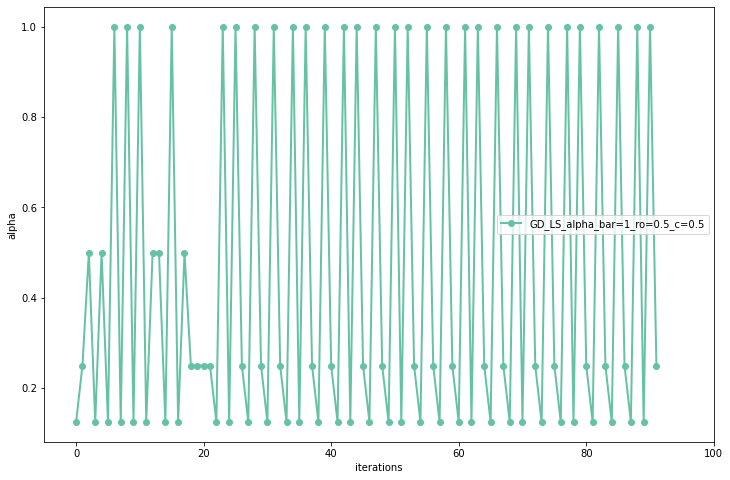

In [55]:
plot([config_gd_ls], y_axis='alpha', xlim_max=100)

## Comparison

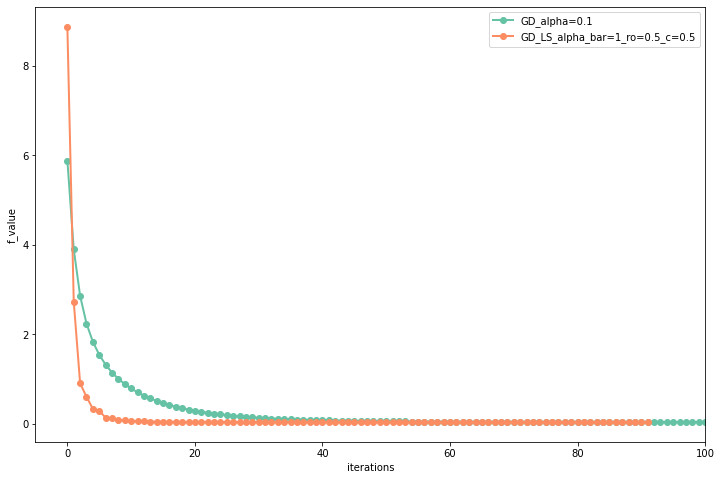

In [56]:
plot([config_gd, config_gd_ls], xlim_max=100)

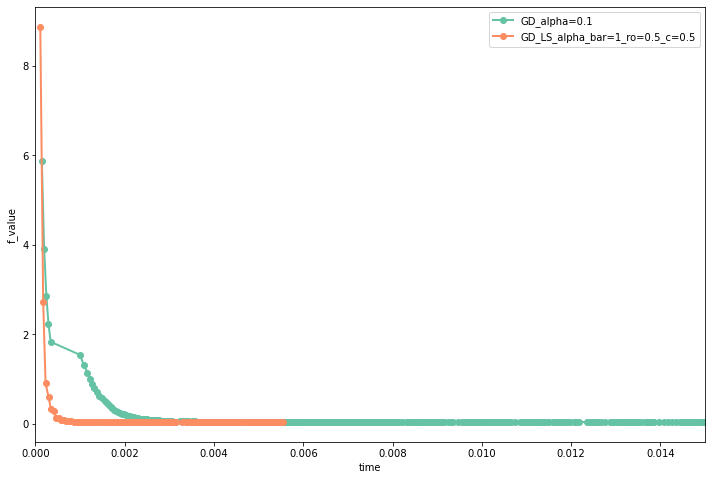

In [85]:
plot([config_gd, config_gd_ls], x_axis='time', time_offset=0, xlim_max=0.015)

# Accelerated Gradient Descent

## Without Backtracking LineSearch

In [58]:
config = []
for alpha_ in [0.1, 0.01, 0.001]:
    agd = accelerated_gradient_descent(ls=ls, alpha=alpha_)
    tmp = {
                'optimation': 'AGD',
                'use_backtracking': False,
                'parameter': {
                    'alpha': str(alpha_),
                },
                'result': agd
            }
    config.append(tmp)
config_ = print_result(config)

GD finished after 292 iterations
GD finished after 1999 iterations
GD finished after 8313 iterations


In [59]:
config_agd = config[0]
config_agd['result']['f_value'][-1], config_agd['result']['time'][-1]

(0.04164591852434318, 0.015442848205566406)

## With Backtracking LineSearch

In [60]:
config = []
for alpha_bar in [0.1,0.5,1]:
    for ro  in [0.1, 0.5, 0.9]:
        for c in [0.1, 0.5, 0.9]:
            agd_ls = accelerated_gradient_descent(ls=ls, use_linesearch=True, alpha_bar=alpha_bar, ro=ro, c=c)
            tmp = {
                'optimation': 'AGD',
                'use_backtracking': True,
                'parameter': {
                    'alpha_bar': str(alpha_bar),
                    'ro': str(ro),
                    'c': str(c)
                },
                'result': agd_ls
            }
            config.append(tmp)
config_ = print_result(config)

GD finished after 187 iterations
GD finished after 272 iterations
GD finished after 394 iterations
GD finished after 371 iterations
GD finished after 272 iterations
GD finished after 332 iterations
GD finished after 371 iterations
GD finished after 292 iterations
GD finished after 292 iterations


/Users/thanhnk/Documents/phuongntm/master/hk2/toi_uu_hoa_nang_cao/advanced-optimization/src/model/Least_Square.py:28: RuntimeWarning: overflow encountered in matmul
  return (x.T @ self.B @ x - self.C_T @ x + self.d)/self.m
/Users/thanhnk/Documents/phuongntm/master/hk2/toi_uu_hoa_nang_cao/advanced-optimization/src/backtracking_method/backtracking_linesearch.py:11: RuntimeWarning: overflow encountered in matmul
  grad_p_k = c*(grad_k.T@p_k)
/Users/thanhnk/Documents/phuongntm/master/hk2/toi_uu_hoa_nang_cao/advanced-optimization/src/backtracking_method/backtracking_linesearch.py:14: RuntimeWarning: invalid value encountered in double_scalars
  while f_new > f_k + alpha*grad_p_k:


GD finished after 1593 iterations
GD finished after 4157 iterations
GD finished after 9999 iterations
GD finished after 207 iterations
GD finished after 217 iterations
GD finished after 411 iterations
GD finished after 652 iterations
GD finished after 209 iterations
GD finished after 261 iterations
GD finished after 1416 iterations
GD finished after 4028 iterations
GD finished after 418 iterations
GD finished after 179 iterations
GD finished after 280 iterations
GD finished after 358 iterations
GD finished after 536 iterations
GD finished after 160 iterations
GD finished after 308 iterations


In [61]:
config_agd_ls = config[25]
config_agd_ls['result']['f_value'][-1], config_agd_ls['result']['time'][-1]

(0.0416459112856251, 0.023491859436035156)

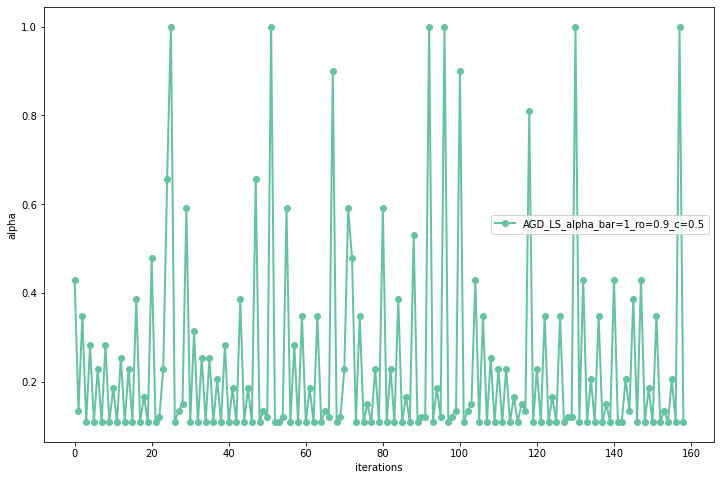

In [62]:
plot([config_agd_ls], y_axis='alpha')

## Comparison

In [63]:
print_result([config_agd, config_agd_ls])

,,stop_iteration,final_fvalue,total_time
algorithm,parameters,,,
AGD,0_alpha=0.1,291,0.041646,0.015443
AGD_LS,1_alpha_bar=1_ro=0.9_c=0.5,159,0.041646,0.023492


,algorithm,parameters,stop_iteration,final_fvalue,total_time
0,AGD,0_alpha=0.1,291,0.041646,0.015443
1,AGD_LS,1_alpha_bar=1_ro=0.9_c=0.5,159,0.041646,0.023492


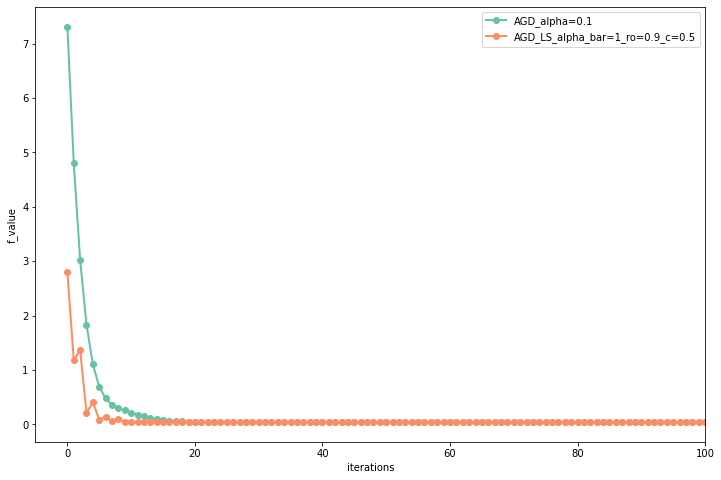

In [64]:
plot([config_agd, config_agd_ls], xlim_max=100)

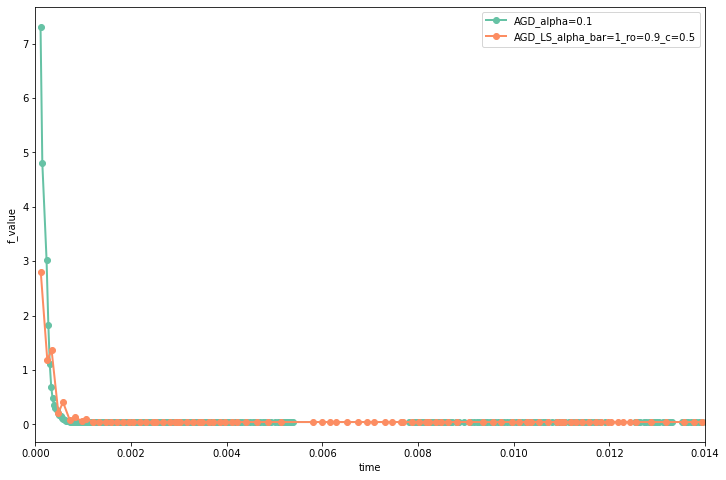

In [84]:
plot([config_agd, config_agd_ls], x_axis='time', time_offset=0, xlim_max=0.014)

# Newton Method

## Without Backtracking LineSearch

In [66]:
config = []
for alpha_ in [1,
               1e-1,
               1e-2,
              ]:
    nt = newton_method(ls=ls, alpha=alpha_)
    tmp = {
                'optimation': 'Newton',
                'use_backtracking': False,
                'parameter': {
                    'alpha': str(alpha_),
                },
                'result': nt
            }
    config.append(tmp)
print_result(config)

GD finished after 1 iterations
GD finished after 128 iterations
GD finished after 1060 iterations


,algorithm,parameters,stop_iteration,final_fvalue,total_time
0,Newton,0_alpha=1,1,0.041646,0.000110
1,Newton,1_alpha=0.1,128,0.041646,0.006165
2,Newton,2_alpha=0.01,1060,0.041646,0.050427


In [67]:
config_nt = config[0]
config_nt['result']['f_value'][-1], config_nt['result']['time'][-1]

(0.0416459112841977, 0.00010991096496582031)

## With Backtracking LineSearch

In [68]:
config = []
for alpha_bar in [1]:
    for ro  in [0.1, 0.5, 0.9]:
        for c in [0.1, 0.5, 0.9]:
            nt_ls = newton_method(ls=ls, use_linesearch=True, alpha_bar=alpha_bar, ro=ro, c=c)
            tmp = {
                'optimation': 'Newton',
                'use_backtracking': True,
                'parameter': {
                    'alpha_bar': str(alpha_bar),
                    'ro': str(ro),
                    'c': str(c)
                },
                'result': nt_ls
            }
            config.append(tmp)
print_result(config)

GD finished after 129 iterations
GD finished after 128 iterations
GD finished after 1049 iterations
GD finished after 49 iterations
GD finished after 104 iterations
GD finished after 386 iterations
GD finished after 10 iterations
GD finished after 86 iterations
GD finished after 296 iterations


,algorithm,parameters,stop_iteration,final_fvalue,total_time
0,Newton_LS,0_alpha_bar=1_ro=0.1_c=0.1,129,0.041646,0.010583
1,Newton_LS,1_alpha_bar=1_ro=0.1_c=0.5,128,0.041646,0.010843
2,Newton_LS,2_alpha_bar=1_ro=0.1_c=0.9,1049,0.041646,0.085856
3,Newton_LS,3_alpha_bar=1_ro=0.5_c=0.1,49,0.041646,0.005867
4,Newton_LS,4_alpha_bar=1_ro=0.5_c=0.5,104,0.041646,0.010343
5,Newton_LS,5_alpha_bar=1_ro=0.5_c=0.9,386,0.041646,0.036759
6,Newton_LS,6_alpha_bar=1_ro=0.9_c=0.1,10,0.041646,0.001361
7,Newton_LS,7_alpha_bar=1_ro=0.9_c=0.5,86,0.041646,0.012718
8,Newton_LS,8_alpha_bar=1_ro=0.9_c=0.9,296,0.041646,0.070330


In [69]:
config_nt_ls = config[6]
config_nt_ls['result']['f_value'][-1], config_nt_ls['result']['time'][-1]

(0.04164591128421987, 0.0013608932495117188)

## Comparison

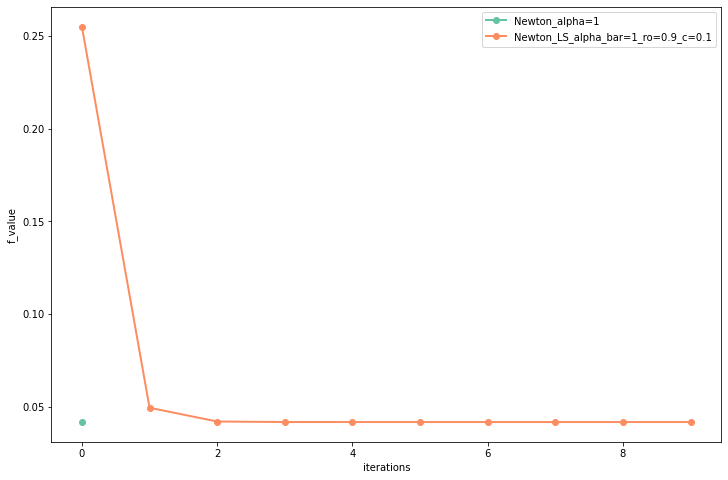

In [70]:
plot([config_nt, config_nt_ls])

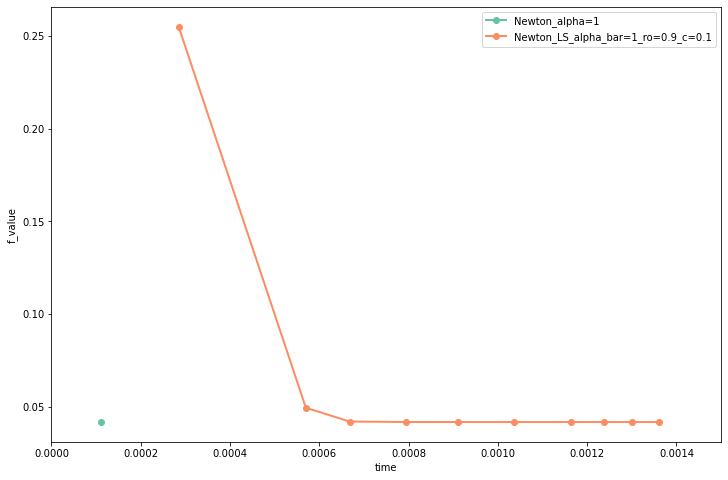

In [83]:
plot([config_nt, config_nt_ls], x_axis='time', time_offset=0, xlim_max=0.0015)

# Final Comparison

In [72]:
final_config = [config_gd, config_gd_ls, config_agd, config_agd_ls, config_nt, config_nt_ls]
print_result(final_config)

,,stop_iteration,final_fvalue,total_time
algorithm,parameters,,,
GD,0_alpha=0.1,409,0.041646,0.020852
GD_LS,1_alpha_bar=1_ro=0.5_c=0.5,92,0.041646,0.005540
AGD,2_alpha=0.1,291,0.041646,0.015443
AGD_LS,3_alpha_bar=1_ro=0.9_c=0.5,159,0.041646,0.023492
Newton,4_alpha=1,1,0.041646,0.000110
Newton_LS,5_alpha_bar=1_ro=0.9_c=0.1,10,0.041646,0.001361


,algorithm,parameters,stop_iteration,final_fvalue,total_time
0,GD,0_alpha=0.1,409,0.041646,0.020852
1,GD_LS,1_alpha_bar=1_ro=0.5_c=0.5,92,0.041646,0.005540
2,AGD,2_alpha=0.1,291,0.041646,0.015443
3,AGD_LS,3_alpha_bar=1_ro=0.9_c=0.5,159,0.041646,0.023492
4,Newton,4_alpha=1,1,0.041646,0.000110
5,Newton_LS,5_alpha_bar=1_ro=0.9_c=0.1,10,0.041646,0.001361


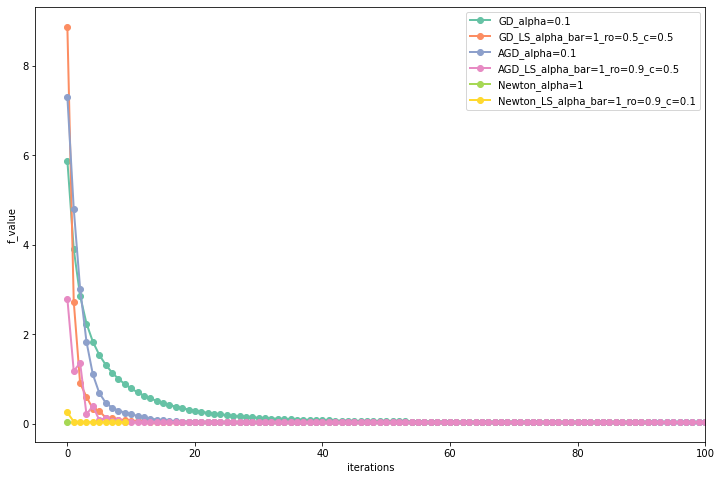

In [73]:
plot(final_config, xlim_max=100)

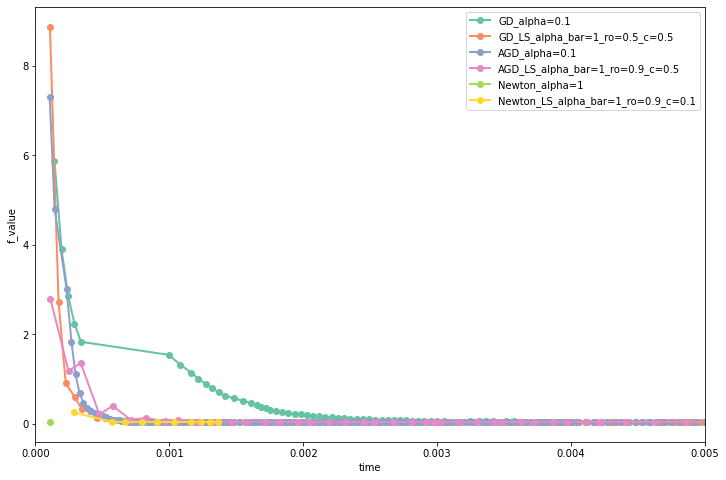

In [80]:
plot(final_config, x_axis='time', time_offset=0, xlim_max=0.005)

# Compare with Sklearn

In [75]:
def regr_metrics(act, pred):
    return (math.sqrt(metrics.mean_absolute_error(act, pred)), metrics.mean_squared_error(act, pred))

In [86]:
def evaluate_model(w, X_test, y_test, x_scaler=None, y_scaler=None):
  if x_scaler != None:
    # inverse transform
    X_test_transformed = x_scaler.transform(X_test)
    X_test_transformed = np.c_[X_test_transformed, np.ones(X_test_transformed.shape[0])]
  y_predict = X_test_transformed @ w
  if y_scaler != None:
    print('use y scaler')
    y_predict_inverse = y_scaler.inverse_transform(y_predict)
  else:
    y_predict_inverse = y_predict
  # tính loss

  loss = regr_metrics(y_test, y_predict_inverse)[1]
  # tính r2
  r2 = metrics.r2_score(y_test, y_predict_inverse)
  # y_test = np.exp(y_test)*1e6
  y_predict_inverse *= 1e6
  return X_test_transformed, y_predict_inverse, loss, r2

X_test_transformed, y_predict_inverse, loss, r2 = evaluate_model(config_nt['result']['x_history'][-1],
                                                                 X_test, y_test, x_scaler)
loss, r2

(0.04489485685820391, 0.6984965787445774)

In [87]:
from sklearn.linear_model import LinearRegression
import time

lr = LinearRegression(fit_intercept=False)
start_time = time.time()
lr.fit(X_train_transformed,b)
end_time = time.time()
print('time', end_time - start_time)

def eval(X_test_transformed, y_test):
    y_predict = lr.predict(X_test_transformed).flatten()
    loss = regr_metrics(y_test, y_predict)[1]
    r2 = metrics.r2_score(y_test, y_predict)
    y_predict *= 1e6
    return loss, r2, y_predict
# loss_train, r2_train = eval(X_train_1, y_train)
# loss_test, r2_test = eval(X_test_1, y_test)

time 0.006645917892456055


In [88]:
opts = []
loss_trains = []
loss_tests = []
r2_trains = []
r2_tests = []
coefs = []
for con in final_config:
  optimation = con['optimation']
  # print(optimation)
  use_bt = con['use_backtracking']
  if use_bt:
    optimation += '_LS'

  result = con['result']
  x = result['x_history'][-1]
  coefs.append(x)
  # munual optimation
  X_train_1, y_train_pred_inverse, loss_train, r2_train = evaluate_model(x, X_train, y_train, x_scaler)
  X_test_1, y_test_pred_inverse, loss_test, r2_test = evaluate_model(x, X_test, y_test, x_scaler)

  opts.append(optimation)
  loss_trains.append(loss_train)
  loss_tests.append(loss_test)
  r2_trains.append(r2_train)
  r2_tests.append(r2_test)

loss_train, r2_train, y_predict_train = eval(X_train_1, y_train)
loss_test, r2_test, y_predict_test = eval(X_test_1, y_test)

opts.append('Sklearn')
loss_trains.append(loss_train)
loss_tests.append(loss_test)
r2_trains.append(r2_train)
r2_tests.append(r2_test)
coefs.append(lr.coef_)
comparison = pd.DataFrame({'algorithm': opts,
              'loss-train': loss_trains,
              'loss-test': loss_tests,
              'r2-train': r2_trains,
              'r2-test': r2_tests})
comparison

ValueError: X has 16 features, but LinearRegression is expecting 15 features as input.

In [89]:
coef_df = pd.DataFrame(data=None, columns=opts)
for x, y in zip(opts, coefs):
  coef_df[x] = y
coef_df

,GD,GD_LS,AGD,AGD_LS,Newton,Newton_LS
0,-0.035084,-0.035085,-0.035054,-0.035086,-0.035087,-0.035087
1,0.032834,0.032832,0.032872,0.032830,0.032830,0.032830
2,0.171327,0.171337,0.171144,0.171344,0.171346,0.171347
3,-0.007727,-0.007728,-0.007716,-0.007728,-0.007728,-0.007728
4,0.003277,0.003275,0.003301,0.003275,0.003274,0.003274
5,0.054878,0.054878,0.054885,0.054878,0.054878,0.054878
6,0.042230,0.042231,0.042221,0.042231,0.042231,0.042231
7,0.017414,0.017414,0.017410,0.017414,0.017414,0.017414
8,0.105666,0.105662,0.105714,0.105661,0.105660,0.105660
9,-0.007986,-0.007989,-0.007934,-0.007990,-0.007991,-0.007991


In [ ]:
df = y_test*1e6
df['Newton'] = y_predict_inverse
df['Sklearn'] = y_predict_test
df